# Resolving Ambiguity in Prepositional Phrase Attachment

The problem of resolving ambiguity in prepositional phrase attachment is one that remains largely unsolved in NLP, and one that pre-trained language models such as BERT will likely not be of much help with. This notebook shows results of predicting prepositional phrase attachments across a subset of the NLVR2 dataset which has been annotated, leveraging a pre-trained language model commonly known as "BERT" (cite). 

We trained an SVM classifier from the output (hidden layers) of the large uncased model from BERT with whole word masking. The results are presented in terms of Cohen's kappa score and F1 score. 

In [1]:
from IPython.display import Image

# Preliminary Steps

In [2]:
# conda create -n python=3.7 ...
# pip install transformers... 

In [3]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn import svm
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import cohen_kappa_score as kappa
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from collections import Counter
from operator import itemgetter

In [4]:
from generator import HuggingFaceGenerator, MaskedPrepGenerator, SpacyModel

In [5]:
np.random.seed(91768)

## Load Dataset (train/test)

In [6]:
datadir = "data"
outputdir = "."

In [7]:
train_data = json.load(open('{}/ppa_train.json'.format(datadir)))
labels_train = [instance['label'] for instance in train_data]

test_data = json.load(open('{}/ppa_test.json'.format(datadir)))
labels_test = [instance['label'] for instance in test_data]

## Using BERT Language Model
We load a pre-trained model from BERT and use it to generate instances for model training. 

In [8]:
bert_model_name = "bert-large-uncased-whole-word-masking"
hf_generator = HuggingFaceGenerator(bert_model_name)

## Transform Dataset (or reload)

In [9]:
train_feature_file = "{}/hf_train.csv".format(outputdir)
test_feature_file = "{}/hf_test.csv".format(outputdir)

In [10]:
if os.path.exists(train_feature_file):
    hf_train = pd.read_csv(train_feature_file, header=None)
else:
    hf_train = hf_generator.generate_dataset(train_data)
    pd.DataFrame(hf_train).to_csv(train_feature_file, header=False,index=False)

In [11]:
if os.path.exists(test_feature_file):
    hf_test = pd.read_csv(test_feature_file, header=None)
else:
    hf_test = hf_generator.generate_dataset(test_data)
    pd.DataFrame(hf_test).to_csv(test_feature_file, header=False,index=False)

# Model Training

In [12]:
clfhf = svm.SVC(gamma=0.0001, C=100., random_state=91768)
clfhf.fit(hf_train, labels_train)

SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=91768, shrinking=True,
    tol=0.001, verbose=False)

In [13]:
preds_test_hf = clfhf.predict(hf_test)

In [14]:
print(sklearn.metrics.classification_report(labels_test, preds_test_hf, digits=3))

              precision    recall  f1-score   support

           N      0.875     0.946     0.909       111
           O      0.667     0.400     0.500        10
           V      0.742     0.639     0.687        36

    accuracy                          0.841       157
   macro avg      0.761     0.662     0.699       157
weighted avg      0.831     0.841     0.832       157



### without 'O'(ther) classification

In [15]:
nvi = [i for i,lbl in enumerate(labels_train) if lbl in ['N','V']]

In [16]:
labels_train_NV = [lbl for lbl in labels_train if lbl in ['N','V']]

In [17]:
hf_train_NV = hf_train.to_numpy()[nvi]
#hf_generator.generate_dataset([td for td,lbl in zip(train_data,labels_train) if lbl in ['N','V']])

In [18]:
hf_train_NV.shape

(435, 16384)

In [19]:
nvi_test = [i for i,lbl in enumerate(labels_test) if lbl in ['N','V']]

In [20]:
hf_test_NV = hf_test.to_numpy()[nvi_test]
#hf_generator.generate_dataset([td for td,lbl in zip(test_data,labels_test) if lbl in ['N','V']])

In [21]:
labels_test_NV = [lbl for lbl in labels_test if lbl in ['N','V']]

In [22]:
clfhf2 = svm.SVC(gamma=0.0001, C=100., random_state=91768)
clfhf2.fit(hf_train_NV, labels_train_NV)

SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=91768, shrinking=True,
    tol=0.001, verbose=False)

In [23]:
preds_test_hf2 = clfhf2.predict(hf_test_NV)

In [24]:
confusion_matrix(labels_test, preds_test_hf)

array([[105,   0,   6],
       [  4,   4,   2],
       [ 11,   2,  23]])

In [25]:
confusion_matrix(labels_test_NV, preds_test_hf2)

array([[104,   7],
       [ 12,  24]])

In [26]:
print(sklearn.metrics.classification_report(labels_test_NV, preds_test_hf2, digits=3))

              precision    recall  f1-score   support

           N      0.897     0.937     0.916       111
           V      0.774     0.667     0.716        36

    accuracy                          0.871       147
   macro avg      0.835     0.802     0.816       147
weighted avg      0.867     0.871     0.867       147



## Applying BERT to the same dataset for the masked prep task... 

In [27]:
mpgen = MaskedPrepGenerator(bert_model_name)

In [28]:
mplabels,mppredictions=mpgen.evaluate_dataset(test_data,use_cuda=True)

(82 correct / 100 total)
(160 correct / 200 total)
(236 correct / 300 total)


In [29]:
accuracy_score(mplabels,mppredictions)

0.7849462365591398

In [30]:
kappa(mplabels, mppredictions)

0.7426407001279878

In [31]:
sklearn.metrics.classification_report(mplabels, mppredictions, digits=3, output_dict=True, zero_division=0)['weighted avg']['f1-score']

0.8111697864740477

## Error Analysis

In [32]:
get_4tpl = lambda x : (x['V']['lemma'],x['N']['lemma'],x['P']['lemma'],x['N2']['lemma'])

In [33]:
spacy_model = SpacyModel()

In [34]:
spacy_preds_train = [spacy_model.predict(t) for t in train_data]

In [35]:
train_tuples = [get_4tpl(td) for td in list(train_data)]
test_tuples = [get_4tpl(td) for td in list(test_data)]

In [36]:
confusion_matrix(labels_test,preds_test_hf,labels=['N','O','V'])

array([[105,   0,   6],
       [  4,   4,   2],
       [ 11,   2,  23]])

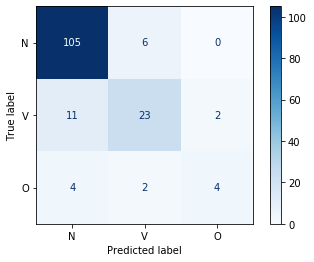

In [37]:
plot_confusion_matrix(clfhf, hf_test, labels_test, labels=['N','V','O'], values_format='d', cmap=plt.cm.Blues)

In [38]:
errors = [(i,lbl,pred) for i,(lbl,pred) in enumerate(zip(labels_test,preds_test_hf)) if not lbl==pred]

In [39]:
def get_err_info(err,data):
    (i,lbl,pred)=err
    td=data[i]
    #print(td['sentence_text'])
    return ((i,*get_4tpl(td),lbl,pred,td['sentence_text']))

In [40]:
error_tuples=[]
for err in errors: 
    # Exclude 'other' cases for now
    if 'O' in err:
        continue
    error_tuples.append(get_err_info(err,test_data))

In [41]:
df = pd.DataFrame(error_tuples, columns=['i','V','N1','P','N2','label','pred','sentence_text'])

In [42]:
df

,i,V,N1,P,N2,label,pred,sentence_text
0,0,be,dog,in,pair,V,N,There are three chow dogs in the image pair.
1,20,wear,ear,on,head,N,V,A girl in long one piece pajamas is wearing mo...
2,28,feature,shape,above,shape,V,N,Each dispenser has a circle shape and an upsid...
3,57,be,dog,in,image,N,V,There is exactly one dog in the right image.
4,64,be,bottle,with,lid,N,V,There is one bottle with a lid and one bottle ...
5,67,have,door,in,section,N,V,Two tall narrow cabinets have at least three u...
6,72,put,leg,on,fence,V,N,putting their right leg high up on a fence.
7,75,have,toy,in,front,V,N,At least one of the dogs has a small toy in fr...
8,78,include,wand,to,right,V,N,The combined images include an uncapped lipsti...
9,83,be,awning,over,machine,V,N,There is an awning over the machines in one of...


In [43]:
# Not sure:
# There are at least 3 deer in a tree...
# There is a dog on a green rug. 
# also not sure what to do about 'next to'

In [44]:
# Some instances seem to be labeled incorrectly
wrong_label_indices = [1,3,12,15]

In [45]:
new_test_labels = [lbl for lbl in labels_test]
for i in df.to_numpy()[wrong_label_indices,0]:
    new_test_labels[i] = 'V'

## Analyze train/dev

In [46]:
spacy_preds = [spacy_model.predict(t) for t in test_data]

In [47]:
classifiers = ['all_noun','spacy','bert']

In [48]:
test_preds = [['N' for i in range(len(labels_test))], spacy_preds, preds_test_hf]

In [49]:
class_reports = {cl: sklearn.metrics.classification_report(labels_test, preds, digits=3, output_dict=True, zero_division=0) 
                 for (cl,preds) in zip(classifiers, test_preds)}

In [50]:
pd.DataFrame([[c, class_reports[c]['weighted avg']['f1-score']] for c in classifiers], columns=['classifier','weighted avg f1-score'])

,classifier,weighted avg f1-score
0,all_noun,0.585655
1,spacy,0.722477
2,bert,0.832010


In [51]:
print(sklearn.metrics.classification_report(labels_test, ['N' for i in range(len(labels_test))], digits=3,zero_division=0))

              precision    recall  f1-score   support

           N      0.707     1.000     0.828       111
           O      0.000     0.000     0.000        10
           V      0.000     0.000     0.000        36

    accuracy                          0.707       157
   macro avg      0.236     0.333     0.276       157
weighted avg      0.500     0.707     0.586       157



In [52]:
print(sklearn.metrics.classification_report(labels_test, spacy_preds, digits=3))

              precision    recall  f1-score   support

           N      0.798     0.928     0.858       111
           O      0.500     0.800     0.615        10
           V      0.667     0.222     0.333        36

    accuracy                          0.758       157
   macro avg      0.655     0.650     0.602       157
weighted avg      0.749     0.758     0.722       157



In [53]:
print(sklearn.metrics.classification_report(labels_test, preds_test_hf, digits=3))

              precision    recall  f1-score   support

           N      0.875     0.946     0.909       111
           O      0.667     0.400     0.500        10
           V      0.742     0.639     0.687        36

    accuracy                          0.841       157
   macro avg      0.761     0.662     0.699       157
weighted avg      0.831     0.841     0.832       157



In [54]:
print(sklearn.metrics.classification_report(labels_train, spacy_preds_train, digits=3))

              precision    recall  f1-score   support

           N      0.780     0.855     0.816       331
           O      0.481     0.703     0.571        37
           V      0.455     0.240     0.314       104

    accuracy                          0.708       472
   macro avg      0.572     0.599     0.567       472
weighted avg      0.685     0.708     0.686       472



In [55]:
def collect_labels(train_tuples, train_labels):
    ngram_labels = {}
    probs = {}
    for tpl,lbl in zip(train_tuples,train_labels):
        triples = [tpl[:3],(tpl[0],*tpl[2:]),tpl[1:]]
        doubles = [(tpl[0],tpl[2]),tpl[1:2],tpl[2:]]
        singles = [tuple([t]) for t in tpl]
        subtuples = [(tpl)] + triples + doubles + singles
        for subtpl in subtuples:
            if subtpl not in ngram_labels:
                ngram_labels[subtpl] = []
            ngram_labels[subtpl].append(lbl)
    return ngram_labels

In [56]:
ngram_labels=collect_labels(train_tuples, labels_train)

In [57]:
support = []
for ngram, labels in ngram_labels.items():
    total = len(labels)
    proportion = len([lbl for lbl in labels if lbl=='N'])/total
    support.append((proportion, total, ngram))

In [58]:
insights = sorted(support, key=itemgetter(1), reverse=True)

In [59]:
rules = {}
proportions = {}
ncounts = {}
for (proportion,total,ngram) in insights: 
    if abs(proportion-0.5)<0.38:
        continue
    if total<9:
        continue
    print("{}: {:.1f}% (N={})".format(ngram,100.0*proportion,total))
    if proportion>0.5:
        rules[ngram]= "N"
    else:
        rules[ngram]= "V"
    proportions[ngram]=proportion
    ncounts[ngram] = total

('of',): 88.3% (N=128)
('with',): 94.2% (N=121)
('show',): 92.3% (N=91)
('contain',): 95.8% (N=72)
('number',): 100.0% (N=60)
('in', 'image'): 11.1% (N=54)
('contain', 'of'): 97.8% (N=45)
('show', 'with'): 97.1% (N=35)
('be', 'in', 'image'): 5.9% (N=34)
('contain', 'number', 'of'): 100.0% (N=30)
('show', 'of'): 95.0% (N=20)
('row',): 100.0% (N=19)
('include',): 94.4% (N=18)
('feature', 'with'): 100.0% (N=16)
('be', 'with'): 93.8% (N=16)
('contain', 'with'): 100.0% (N=15)
('be', 'dog', 'in'): 10.0% (N=10)
('dog', 'in', 'image'): 10.0% (N=10)
('color',): 100.0% (N=10)
('be', 'in', 'total'): 0.0% (N=9)
('in', 'total'): 0.0% (N=9)
('of', 'image'): 11.1% (N=9)
('balloon',): 100.0% (N=9)


In [60]:
errors = [(i,lbl,pred) for i,(lbl,pred) in enumerate(zip(new_test_labels,preds_test_hf)) if not lbl==pred]

In [61]:
error_tuples=[]
for err in errors: 
    # Exclude 'other' cases for now
    if 'O' in err:
        continue
    error_tuples.append(get_err_info(err,test_data))

In [62]:
df = pd.DataFrame(error_tuples, columns=['i','V','N1','P','N2','label','pred','sentence_text'])

In [63]:
errtpls=[]
errlbls=[]
for row in df.iterrows():
    tpl = (row[1]['V'],row[1]['N1'],row[1]['P'],row[1]['N2'])
    lbl = row[1]['pred']
    errtpls.append(tpl)
    errlbls.append(lbl)


In [64]:
err_ngram_labels = collect_labels(errtpls,errlbls)

In [65]:
for ngl,nglbl in err_ngram_labels.items():
    nglbl = nglbl[0]
    if ngl in rules:
        print(ngl,nglbl,rules[ngl],proportions[ngl],ncounts[ngl])
    

('be', 'dog', 'in') N V 0.1 10
('be', 'with') V N 0.9375 16
('with',) V N 0.9421487603305785 121
('include',) N N 0.9444444444444444 18
('show',) N N 0.9230769230769231 91
('be', 'in', 'image') N V 0.058823529411764705 34
('in', 'image') N V 0.1111111111111111 54


In [66]:
def get_subtuples(tpl):
    triples = [tpl[:3],(tpl[0],*tpl[2:]),tpl[1:]]
    doubles = [(tpl[0],tpl[2]),tpl[1:2],tpl[2:]]
    singles = [tuple([t]) for t in tpl]
    subtuples = [(tpl)] + triples + doubles + singles
    return subtuples

In [67]:
for (i,v,n1,p,n2,lbl,pred,senttxt) in error_tuples:
    subtpls = get_subtuples((v,n1,p,n2))
    matching_rules = [ngl for ngl in subtpls if ngl in rules]
    if len(matching_rules)==0:
        print((v,n1,p,n2),lbl,pred,senttxt)
        continue
    props = [proportions[ngram] for ngram in matching_rules]
    ncnts = [ncounts[ngram] for ngram in matching_rules]
    print((v,n1,p,n2),[(r,p,n) for (r,p,n) in zip(matching_rules,props,ncnts)],senttxt)
    # Weird with case of absolute

('be', 'dog', 'in', 'pair') [(('be', 'dog', 'in'), 0.1, 10)] There are three chow dogs in the image pair.
('feature', 'shape', 'above', 'shape') V N Each dispenser has a circle shape and an upside-down raindrop shape on its front, and at least one dispenser features the raindrop shape above the circle shape.
('be', 'bottle', 'with', 'lid') [(('be', 'with'), 0.9375, 16), (('with',), 0.9421487603305785, 121)] There is one bottle with a lid and one bottle without a lid.
('have', 'door', 'in', 'section') N V Two tall narrow cabinets have at least three upper shelves and have flat tops, but only one has two doors in its lower section.
('put', 'leg', 'on', 'fence') V N putting their right leg high up on a fence.
('have', 'toy', 'in', 'front') V N At least one of the dogs has a small toy in front of him.
('include', 'wand', 'to', 'right') [(('include',), 0.9444444444444444, 18)] The combined images include an uncapped lipstick wand to the right of a capped lipstick, and a squarish smear of re

In [83]:
len(train_tuples)

472

In [84]:
verbs = 

In [85]:
len(verbs)

472

In [107]:
verbs_df = pd.DataFrame.from_dict(Counter([v for (v,n1,p,n2) in train_tuples]),orient='index') \
    .reset_index() \
    .rename(columns={"index":"verb",0:"count"}) \
    .sort_values(by='count', ascending=False, ignore_index=True, inplace=False)

In [108]:
verbs_df

,verb,count
0,be,117
1,show,91
2,contain,72
3,feature,32
4,have,29
...,...,...
63,plow,1
64,cap,1
65,make,1
66,bear,1


In [110]:
presentation_verb_lemmas = ['include','feature','show','be','wear','cover','contain','have']

In [129]:
pres_verbs_df=verbs_df.isin({'verb': presentation_verb_lemmas})

In [139]:
presentation_verb_test = verbs_df['verb'].map(lambda x: x in presentation_verb_lemmas)

In [143]:
nonpresentation_verb_test = verbs_df['verb'].map(lambda x: x not in presentation_verb_lemmas)

In [ ]:
verbs_df[]

In [147]:
s="hold, face, see, match, depict, look, view, stare, angle, expose, draw, receive, frame, accompany, wave"

In [150]:
pres_candidates = s.split(", ")

In [151]:
pres_candidates

['hold',
 'face',
 'see',
 'match',
 'depict',
 'look',
 'view',
 'stare',
 'angle',
 'expose',
 'draw',
 'receive',
 'frame',
 'accompany',
 'wave']

In [154]:
[v for v in verbs_df[nonpresentation_verb_test].verb.tolist() if v not in pres_candidates]

['mash',
 'stand',
 'touch',
 'fold',
 'park',
 'eat',
 'fall',
 'place',
 'bound',
 'rise',
 'clutch',
 'push',
 'vend',
 'color',
 'shape',
 'use',
 'tie',
 'stir',
 'sit',
 'repeat',
 'contrast',
 'recline',
 'sle',
 'recess',
 'feed',
 'lower',
 'lift',
 'set',
 'head',
 'back',
 'groom',
 'trim',
 'roll',
 'stop',
 'spot',
 'oppose',
 'turn',
 'slide',
 'fill',
 'dry',
 'plow',
 'cap',
 'make',
 'bear',
 'grasp']

In [155]:
prescand_verb_test = verbs_df['verb'].map(lambda x : x in presentation_verb_lemmas or x in pres_candidates)

In [161]:
verbs_df[prescand_verb_test].sum(axis=0,numeric_only=True)

count    419
dtype: int64

In [162]:
verbs_df.sum(axis=0,numeric_only=True)

count    472
dtype: int64

In [163]:
419/472

0.8877118644067796

In [164]:
verbs_df[presentation_verb_test].sum(axis=0,numeric_only=True)/len(train_tuples)

count    0.800847
dtype: float64

In [165]:
# Presentation verbs identified comprise 80% of the training data
# Another 8% or so seem like they might belong to this category
# The rest (12-20% of the data) are not in this category (so would attach to noun). 



In [166]:
pres_verb_tuples = [((v,n1,p,n2),l) for ((v,n1,p,n2),l) in zip(train_tuples,labels_train) if v in presentation_verb_lemmas]

In [167]:
bees = [(pv[0][1],pv[0][2],pv[0][3],pv[1]) for pv in pres_verb_tuples if pv[0][0]=='be']

In [168]:
Counter([b[1] for b in bees])

Counter({'of': 26,
         'in': 60,
         'with': 16,
         'on': 9,
         'to': 1,
         'behind': 1,
         'near': 1,
         'withe': 1,
         'per': 1,
         'below': 1})

In [169]:
Counter([(b[1],b[3]) for b in bees])

Counter({('of', 'N'): 21,
         ('in', 'V'): 51,
         ('with', 'N'): 15,
         ('in', 'N'): 9,
         ('of', 'O'): 5,
         ('on', 'N'): 2,
         ('to', 'V'): 1,
         ('on', 'V'): 7,
         ('behind', 'V'): 1,
         ('near', 'N'): 1,
         ('withe', 'N'): 1,
         ('per', 'N'): 1,
         ('with', 'V'): 1,
         ('below', 'N'): 1})

In [170]:
[b for b in bees if b[1]=='on']

[('beetle', 'on', 'clod', 'N'),
 ('ball', 'on', 'grass', 'V'),
 ('broccoli', 'on', 'towel', 'V'),
 ('container', 'on', 'right', 'V'),
 ('container', 'on', 'left', 'V'),
 ('lipstick', 'on', 'image', 'V'),
 ('dog', 'on', 'beach', 'V'),
 ('chimney', 'on', 'top', 'N'),
 ('spoon', 'on', 'table', 'V')]

"chimney on top" seems to be the only one in a permanent state

In [171]:
[t for t in train_data if t['N']['lemma']=='chimney']

[{'sentence_text': 'IN at least one image there are three chimney on top of the house.',
  'label': 'N',
  'V': {'text': 'are',
   'source': 'nlvr2_dev_035.text.s.22.w.7',
   'pos_tag': 'VBP',
   'lemma': 'be',
   'trail_space': True},
  'N': {'text': 'chimney',
   'source': 'nlvr2_dev_035.text.s.22.w.9',
   'pos_tag': 'NN',
   'lemma': 'chimney',
   'trail_space': True},
  'P': {'text': 'on',
   'source': 'nlvr2_dev_035.text.s.22.w.10',
   'pos_tag': 'IN',
   'lemma': 'on',
   'trail_space': True},
  'N2': {'text': 'top',
   'source': 'nlvr2_dev_035.text.s.22.w.11',
   'pos_tag': 'NN',
   'lemma': 'top',
   'trail_space': True},
  'tokenized_sentence': [['IN',
    'nlvr2_dev_035.text.s.22.w.1',
    'IN',
    'in',
    True],
   ['at', 'nlvr2_dev_035.text.s.22.w.2', 'RB', 'at', True],
   ['least', 'nlvr2_dev_035.text.s.22.w.3', 'RBS', 'least', True],
   ['one', 'nlvr2_dev_035.text.s.22.w.4', 'CD', 'one', True],
   ['image', 'nlvr2_dev_035.text.s.22.w.5', 'NN', 'image', True],
   ['ther

In [172]:
[b for b in bees if b[1]=='in' and b[3]=='N']

[('filling', 'in', 'bread', 'N'),
 ('man', 'in', 'sleeve', 'N'),
 ('mammal', 'in', 'image', 'N'),
 ('dog', 'in', 'image', 'N'),
 ('female', 'in', 'bikini', 'N'),
 ('cover', 'in', 'stripe', 'N'),
 ('woman', 'in', 'gown', 'N'),
 ('jellyfish', 'in', 'water', 'N'),
 ('plug', 'in', 'basin', 'N')]

In [173]:
[t for t in train_data if t['N']['lemma']=='plug' and t['N2']['lemma']=='basin']

[{'sentence_text': 'There is a silver drain plug in the basin in the image on the right.',
  'label': 'N',
  'V': {'text': 'is',
   'source': 'nlvr2_dev_039.text.s.29.w.2',
   'pos_tag': 'VBZ',
   'lemma': 'be',
   'trail_space': True},
  'N': {'text': 'plug',
   'source': 'nlvr2_dev_039.text.s.29.w.6',
   'pos_tag': 'NN',
   'lemma': 'plug',
   'trail_space': True},
  'P': {'text': 'in',
   'source': 'nlvr2_dev_039.text.s.29.w.7',
   'pos_tag': 'IN',
   'lemma': 'in',
   'trail_space': True},
  'N2': {'text': 'basin',
   'source': 'nlvr2_dev_039.text.s.29.w.9',
   'pos_tag': 'NN',
   'lemma': 'basin',
   'trail_space': True},
  'tokenized_sentence': [['There',
    'nlvr2_dev_039.text.s.29.w.1',
    'EX',
    'there',
    True],
   ['is', 'nlvr2_dev_039.text.s.29.w.2', 'VBZ', 'be', True],
   ['a', 'nlvr2_dev_039.text.s.29.w.3', 'DT', 'a', True],
   ['silver', 'nlvr2_dev_039.text.s.29.w.4', 'JJ', 'silver', True],
   ['drain', 'nlvr2_dev_039.text.s.29.w.5', 'NN', 'drain', True],
   ['plu

In [174]:
[t for t in train_data if t['N']['lemma']=='jellyfish' and t['N2']['lemma']=='water']

[{'sentence_text': 'In at least one image there is a single jellyfish in water with blue tentacles stretching up.',
  'label': 'N',
  'V': {'text': 'is',
   'source': 'nlvr2_dev_039.text.s.16.w.7',
   'pos_tag': 'VBZ',
   'lemma': 'be',
   'trail_space': True},
  'N': {'text': 'jellyfish',
   'source': 'nlvr2_dev_039.text.s.16.w.10',
   'pos_tag': 'NN',
   'lemma': 'jellyfish',
   'trail_space': True},
  'P': {'text': 'in',
   'source': 'nlvr2_dev_039.text.s.16.w.11',
   'pos_tag': 'IN',
   'lemma': 'in',
   'trail_space': True},
  'N2': {'text': 'water',
   'source': 'nlvr2_dev_039.text.s.16.w.12',
   'pos_tag': 'NN',
   'lemma': 'water',
   'trail_space': True},
  'tokenized_sentence': [['In',
    'nlvr2_dev_039.text.s.16.w.1',
    'IN',
    'in',
    True],
   ['at', 'nlvr2_dev_039.text.s.16.w.2', 'RB', 'at', True],
   ['least', 'nlvr2_dev_039.text.s.16.w.3', 'RBS', 'least', True],
   ['one', 'nlvr2_dev_039.text.s.16.w.4', 'CD', 'one', True],
   ['image', 'nlvr2_dev_039.text.s.16.w.

I'm not sure any of the above noun attachments is correct!

In [175]:
# I want to see the whole sentence! 
[t for t in train_data if t['N']['lemma']=='woman' and t['N2']['lemma']=='gown']

[{'sentence_text': 'In at least one image there is a woman in a mostly blue graduation gown with short hair and a blue cap.',
  'label': 'N',
  'V': {'text': 'is',
   'source': 'nlvr2_dev_031.text.s.26.w.7',
   'pos_tag': 'VBZ',
   'lemma': 'be',
   'trail_space': True},
  'N': {'text': 'woman',
   'source': 'nlvr2_dev_031.text.s.26.w.9',
   'pos_tag': 'NN',
   'lemma': 'woman',
   'trail_space': True},
  'P': {'text': 'in',
   'source': 'nlvr2_dev_031.text.s.26.w.10',
   'pos_tag': 'IN',
   'lemma': 'in',
   'trail_space': True},
  'N2': {'text': 'gown',
   'source': 'nlvr2_dev_031.text.s.26.w.15',
   'pos_tag': 'NN',
   'lemma': 'gown',
   'trail_space': True},
  'tokenized_sentence': [['In',
    'nlvr2_dev_031.text.s.26.w.1',
    'IN',
    'in',
    True],
   ['at', 'nlvr2_dev_031.text.s.26.w.2', 'RB', 'at', True],
   ['least', 'nlvr2_dev_031.text.s.26.w.3', 'RBS', 'least', True],
   ['one', 'nlvr2_dev_031.text.s.26.w.4', 'CD', 'one', True],
   ['image', 'nlvr2_dev_031.text.s.26.w.5

In [176]:
#Conclusion: 
# 'be N in/on(/above/behind/below/beneath/next-to)' => V
# 'be N with' => N


In [177]:
nonpres_verb_tuples = [((v,n1,p,n2),l) for ((v,n1,p,n2),l) in zip(train_tuples,labels_train) if v not in presentation_verb_lemmas]

In [178]:
nonpres_verb_tuples

[(('feed', 'duck', 'through', 'tube'), 'V'),
 (('hold', 'knife', 'over', 'food'), 'V'),
 (('lower', 'face', 'in', 'content'), 'O'),
 (('face', 'reclining', 'on', 'grass'), 'N'),
 (('lift', 'weight', 'in', 'image'), 'O'),
 (('set', 'sun', 'of', 'image'), 'O'),
 (('hold', 'dog', 'of', 'image'), 'O'),
 (('eat', 'food', 'from', 'bowl'), 'V'),
 (('head', 'righward', 'in', 'image'), 'O'),
 (('stand', 'leg', 'to', 'dog'), 'N'),
 (('face', 'buffalo', 'in', 'image'), 'O'),
 (('back', 'hutch', 'on', 'top'), 'N'),
 (('groom', 'one', 'on', 'left'), 'N'),
 (('trim', 'canopy', 'on', 'rug'), 'N'),
 (('roll', 'dough', 'of', 'picture'), 'O'),
 (('look', 'chow', 'with', 'tongue'), 'N'),
 (('stop', 'bus', 'with', 'people'), 'N'),
 (('recess', 'area', 'with', 'wall'), 'N'),
 (('hold', 'paper', 'at', 'side'), 'O'),
 (('spot', 'ray', 'in', 'ocean'), 'N'),
 (('hold', 'something', 'to', 'mouth'), 'V'),
 (('hold', 'item', 'in', 'paw'), 'V'),
 (('turn', 'puppy', 'with', 'paw'), 'N'),
 (('match', 'headband', 'wi

In [180]:
pres_verb_tuples

[(('feature', 'jellyfish', 'with', 'tentacle'), 'N'),
 (('include', 'bird', 'with', 'wing'), 'N'),
 (('contain', 'number', 'of', 'lemon'), 'N'),
 (('include', 'mass', 'of', 'zebra'), 'N'),
 (('be', 'total', 'of', 'pelican'), 'N'),
 (('be', 'part', 'of', 'stack'), 'N'),
 (('contain', 'number', 'of', 'syrinx'), 'N'),
 (('be', 'skunk', 'in', 'total'), 'V'),
 (('contain', 'laptop', 'with', 'screen'), 'N'),
 (('be', 'bag', 'with', 'handle'), 'N'),
 (('feature', 'car', 'with', 'top'), 'N'),
 (('be', 'pair', 'of', 'antelope'), 'N'),
 (('feature', 'building', 'with', 'structure'), 'N'),
 (('show', 'pack', 'of', 'towel'), 'N'),
 (('show', 'flower', 'below', 'bunch'), 'N'),
 (('include', 'row', 'of', 'corgi'), 'N'),
 (('contain', 'version', 'of', 'side'), 'N'),
 (('feature', 'flower', 'on', 'porcelain'), 'N'),
 (('feature', 'puppy', 'near', 'fence'), 'N'),
 (('be', 'filling', 'in', 'bread'), 'N'),
 (('be', 'puppy', 'with', 'fur'), 'N'),
 (('be', 'animal', 'in', 'total'), 'V'),
 (('show', 'floret

In [181]:
pres_verb_df = pd.DataFrame([[*t[0],t[1]] for t in pres_verb_tuples], columns=['verb','noun','prep','pobj','label'])

In [182]:
pres_verb_df

,verb,noun,prep,pobj,label
0,feature,jellyfish,with,tentacle,N
1,include,bird,with,wing,N
2,contain,number,of,lemon,N
3,include,mass,of,zebra,N
4,be,total,of,pelican,N
...,...,...,...,...,...
373,contain,animal,with,body,N
374,show,chimpanzee,in,tree,N
375,wear,cap,with,tassel,N
376,be,drawer,below,squared,N


In [185]:
Counter(pres_verb_df.label.tolist())

Counter({'N': 277, 'V': 82, 'O': 19})

In [186]:
Counter(pres_verb_df.verb.tolist())

Counter({'feature': 32,
         'include': 18,
         'contain': 72,
         'be': 117,
         'show': 91,
         'cover': 2,
         'wear': 17,
         'have': 29})

In [190]:
pres_verb_df[pres_verb_df['verb']=='wear']

,verb,noun,prep,pobj,label
27,wear,leash,in,image,O
40,wear,ribbon,around,neck,N
49,wear,collar,with,head,O
58,wear,robe,with,stripe,N
82,wear,robe,with,stripe,N
92,wear,glove,of,image,O
93,wear,glove,of,image,O
147,wear,something,with,tassle,N
158,wear,outfit,in,shade,N
173,wear,type,of,coat,N


In [193]:
pres_verb_df.to_csv('data/presentation_verbs.csv',index=False)

In [194]:
df=pd.read_csv('data/presentation_verbs_with_state.csv')

In [195]:
df

,verb,noun,prep,pobj,label,mod_state_mutable,Unnamed: 6
0,feature,jellyfish,with,tentacle,N,N,NaN
1,include,bird,with,wing,N,N,NaN
2,contain,number,of,lemon,N,N,NaN
3,include,mass,of,zebra,N,N,NaN
4,be,total,of,pelican,N,N,NaN
...,...,...,...,...,...,...,...
373,contain,animal,with,body,N,N,NaN
374,show,chimpanzee,in,tree,N,Y,NaN
375,wear,cap,with,tassel,N,N,NaN
376,be,drawer,below,squared,N,?,NaN


In [198]:
# Want PP+POBJ for all cases with mod_state_mutable=Y
matches=list(df[df['mod_state_mutable']=='Y'].itertuples(index=False,name=None))

In [199]:
pp_matches = [(x[2],x[3]) for x in matches]

In [201]:
pp_matches = set(pp_matches)

In [209]:
corrected_preds = []
ann_vs_predV = []
for i,(tt,lbl,spc) in enumerate(zip(test_tuples, labels_test, spacy_preds)):
    pp = (tt[2],tt[3])
    
    if pp in pp_matches:
        if lbl!='V':
            print("E:",tt)
            ann_vs_predV.append(tt)
        corrected_preds.append('V')
    else:
        corrected_preds.append(spc)

E: ('form', 'screen', 'in', 'front')
E: ('hold', 'dog', 'of', 'image')
E: ('leave', 'pig', 'in', 'image')
E: ('show', 'hound', 'on', 'grass')
E: ('have', 'hole', 'in', 'front')
E: ('be', 'dog', 'in', 'image')
E: ('be', 'pillow', 'of', 'image')
E: ('show', 'cover', 'on', 'side')
E: ('feature', 'oval', 'on', 'image')
E: ('view', 'head', 'on', 'left')
E: ('surround', 'table', 'in', 'image')
E: ('flesh', 'fruit', 'on', 'top')
E: ('contain', 'gorilla', 'in', 'image')
E: ('wear', 'pack', 'in', 'image')
E: ('feature', 'dog', 'on', 'left')
E: ('mash', 'potato', 'in', 'bowl')
E: ('be', 'dog', 'on', 'right')
E: ('show', 'person', 'in', 'sleeve')
E: ('show', 'skunk', 'in', 'profile')
E: ('be', 'deer', 'in', 'tree')
E: ('leave', 'display', 'in', 'image')
E: ('be', 'spoon', 'on', 'top')
E: ('show', 'buffalo', 'in', 'water')


In [210]:
err_df = pd.DataFrame(ann_vs_predV,columns=['verb','noun','prep','pobj'])

In [ ]:
# Make a table of this, show it... 
# Flag cases I'm still unsure about

In [211]:
err_df

,verb,noun,prep,pobj
0,form,screen,in,front
1,hold,dog,of,image
2,leave,pig,in,image
3,show,hound,on,grass
4,have,hole,in,front
5,be,dog,in,image
6,be,pillow,of,image
7,show,cover,on,side
8,feature,oval,on,image
9,view,head,on,left


In [206]:
print(sklearn.metrics.classification_report(labels_test, corrected_preds, digits=3))

              precision    recall  f1-score   support

           N      0.916     0.784     0.845       111
           O      0.375     0.300     0.333        10
           V      0.519     0.778     0.622        36

    accuracy                          0.752       157
   macro avg      0.603     0.621     0.600       157
weighted avg      0.790     0.752     0.761       157



In [208]:
print(sklearn.metrics.classification_report(new_test_labels, corrected_preds, digits=3))

              precision    recall  f1-score   support

           N      0.905     0.804     0.851       107
           O      0.375     0.300     0.333        10
           V      0.574     0.775     0.660        40

    accuracy                          0.764       157
   macro avg      0.618     0.626     0.615       157
weighted avg      0.787     0.764     0.770       157



In [ ]:
# Disappointing, but I think error analysis will show
# that the annotations are wrong, or at least questionable
...show test cases where annotation and correction disagree